## Mood Detector With Tensorflow

In [1]:
# Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf  # Correct way to import TensorFlow
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


The next code defines our image input size, batch size (how many images are processed at once), number of color channels (RGB), and how many times the model will train on the full dataset (epochs).

In [27]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [28]:
# Lloading the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "mood_resized",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE 
    
)

print("The total batches in the dataset is", len(dataset))

Found 1712 files belonging to 5 classes.
The total batches in the dataset is 54


In [29]:
# checking the class names
class_names = dataset.class_names
class_names

['Sad', 'Surprised', 'angry', 'happy', 'normal']

(32, 256, 256, 3)


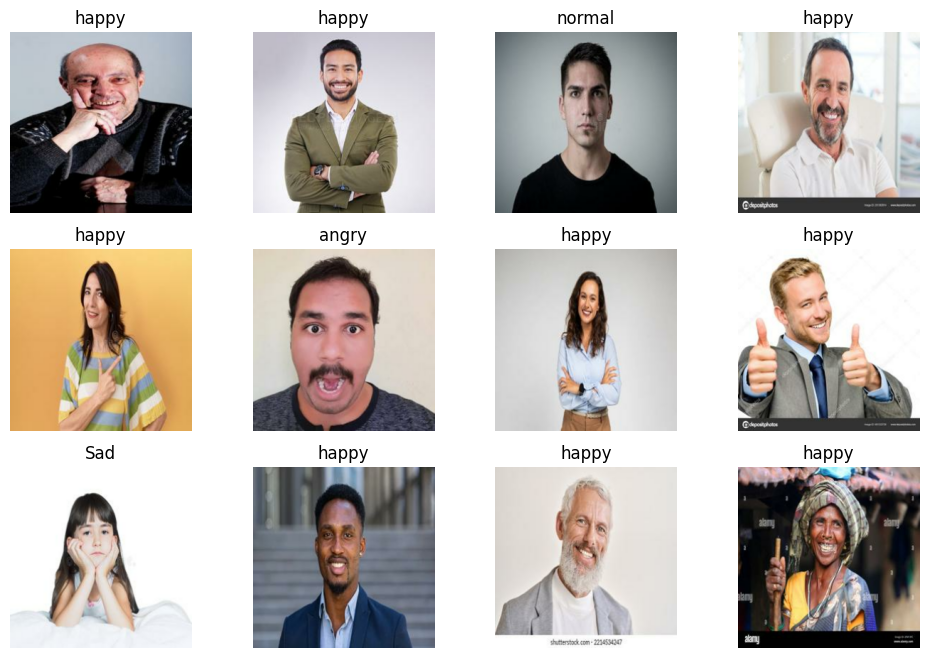

In [30]:
plt.figure(figsize = (12,8))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    for i in range(min(12, image_batch.shape[0])):
        ax= plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i].numpy()])
        plt.axis("off")
        


In [33]:
# Splitting the dataset into train, test and validation
# 80% training
# 10% validation 
# # 10% test

def get_dataset_partitions(ds, train_split=0.8, val_split=0.2, shuffle = True, shuffle_size= 10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)  #seed is for predictability
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    
    
    
    return train_ds, val_ds

In [34]:
train_ds, val_ds = get_dataset_partitions(dataset)
len(train_ds), len(val_ds)

(43, 10)

In [35]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


In [36]:
# preprocessing/scaling the images

resize_and_rescale = Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE), # Accepts image input of fixed shape
    layers.Rescaling(1.0/255),
    ])

In [37]:
# Data augmentation generates new images by slightly modifying existing ones
# This helps to prevent overfitting by providing more diverse training data
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.2, 0.2)
])

In [42]:
input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5
model = models.Sequential([
    layers.Input(shape=input_shape),                # Input layer
    resize_and_rescale,
    data_augmentation,                                        # Data augmentation layer
    layers.Conv2D(32, (3,3), activation='relu'),    # 32 filters will be detected. kernel size of 3x3
    layers.MaxPooling2D((2,2)),                     #  Takes a small region and keeps the maximum value
    Dropout(0.5),                                   #prevents overfitting by making the model less reliant on any one neuron
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    Dropout(0.5),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    Dropout(0.5),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    Dropout(0.5),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    Dropout(0.5),
    layers.Dense(n_classes, activation='softmax')   # output layer with softmax activation for multi-class classification
    ])

model.build(input_shape = (None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

In [43]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,453 (3.42 MB)

 Trainable params: 896,453 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
# compile the model
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
#  The variable history is used to store the training history returned by model.fit
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 1/50


43/43 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.3970 - loss: 1.4212 - val_accuracy: 0.3250 - val_loss: 1.5288
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.4096 - loss: 1.4179 - val_accuracy: 0.2844 - val_loss: 1.6367
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.4242 - loss: 1.3617 - val_accuracy: 0.2969 - val_loss: 1.6329
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.4072 - loss: 1.3900 - val_accuracy: 0.3000 - val_loss: 1.6087
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.4128 - loss: 1.3756 - val_accuracy: 0.3344 - val_loss: 1.5627
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.4323 - loss: 1.3970 - val_accuracy: 0.3313 - val_loss: 1.5112
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.4450 - loss: 1.3571 - val_accuracy: 0.3562 - val_loss: 1.5098
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.4367 - loss: 1.4037 - val_accuracy: 0.3656 - val_loss: 1.4703
Epo

KeyboardInterrupt: 

In [49]:
scores = model.evaluate(val_ds)

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 262ms/step - accuracy: 0.3843 - loss: 1.4660
